In [1]:
import sys

!{sys.executable} -m pip install sagemaker pandas numpy --upgradeb


Usage:   
  /home/ec2-user/anaconda3/envs/python3/bin/python -m pip install [options] <requirement specifier> [package-index-options] ...
  /home/ec2-user/anaconda3/envs/python3/bin/python -m pip install [options] -r <requirements file> [package-index-options] ...
  /home/ec2-user/anaconda3/envs/python3/bin/python -m pip install [options] [-e] <vcs project url> ...
  /home/ec2-user/anaconda3/envs/python3/bin/python -m pip install [options] [-e] <local project path> ...
  /home/ec2-user/anaconda3/envs/python3/bin/python -m pip install [options] <archive url/path> ...

no such option: --upgradeb


In [2]:
import sagemaker

sess = sagemaker.Session()
bucket = 'cnk-datalake'
prefix = "DITU_data/model"

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [3]:
! pip install xgboost
! pip install lightgbm

     |████████████████████████████████| 173.6 MB 12 kB/s              
     |████████████████████████████████| 2.0 MB 23.2 MB/s            


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
import math
# plot feature importance manually
from xgboost import XGBClassifier
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import csv

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
import math
# plot feature importance manually
from xgboost import XGBClassifier
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import csv

In [6]:
acierta=pd.read_csv("coi_Acierta + Batch_2210858_AciertaMas.csv")
pd.set_option("display.max_columns", 500)
## eliminamos las columnas que no nos sirven
acierta=acierta[['Número-Id','Puntaje']].rename(columns={'Número-Id':'cc','Puntaje':'score_experian'})

In [7]:
qualities=pd.read_csv("Qualities.csv")
variables_to_analize=qualities.columns[[('CO' in qualities.columns[i]) or ('ID'==qualities.columns[i]) for i in range(len(qualities.columns))]].tolist()
qualities=qualities[variables_to_analize]

In [8]:
qualities_2=pd.read_csv('qualities_segundo_bundle.csv')
variables_to_analize=qualities_2.columns[[('CO' in qualities_2.columns[i]) or ('ID'==qualities_2.columns[i]) for i in range(len(qualities_2.columns))]].tolist()
## dejamos solo las columnas que nos sirven de qualities
qualities_2=qualities_2[variables_to_analize]

acierta_2=pd.read_csv('acierta_segundo_bundle.csv')
## eliminamos las columnas que no nos sirven y las renombramos
acierta_2=acierta_2[['cc','score_experian']]

In [9]:
## pegamos la información de acierta de los dos bundles

acierta_=pd.concat([acierta_2,acierta])
#acierta_=acierta_2.copy(deep=True)
## eliminamos a todos los clientes que ya teniamos
acierta_.drop_duplicates(subset='cc',inplace=True)
acierta_

,cc,score_experian
0,3.070389e+06,269.0
1,3.133689e+06,742.0
2,3.190351e+06,830.0
3,3.379638e+06,819.0
4,3.380998e+06,757.0
...,...,...
1944,1.193581e+09,0.0
1953,1.214724e+09,0.0
1968,1.233499e+09,0.0
1979,1.233909e+09,0.0


In [10]:
## las variables quee estan en ambas bases de datos.
columnas_intersection=qualities_2.columns[np.isin(qualities_2.columns.tolist(),qualities.columns.tolist())]


## pegamos la información de qualities de los dos bundles

qualities_=pd.concat([qualities_2,qualities])
#qualities_=qualities_2.copy(deep=True)
## eliminamos a todos los clientes que ya teniamos
qualities_.drop_duplicates(subset='ID',inplace=True)

## nos quedamos con solo las qualities que estan en ambas bases de datos
qualities=qualities_[columnas_intersection]

In [11]:
# Convertir -1,-2,-3,-4 en NaN
qualities_dropna = qualities.copy(deep=True)
#qualities_dropna = qualities.replace([-1, -2, -3, -4], np.nan)

# Eliminar las variables que tengan más de threshold NaN
def dropna_by_na_number(df, threshold=500):
    print('initial shape: ', df.shape)
    na_number = df.isna().sum().sort_values().reset_index()
    na_number.columns = ['variable', 'na_number']

    na_threshold = len(df) - threshold
    print('theshold is more drop if nas are more than: ', na_threshold)
    na_variables = na_number[na_number.na_number > na_threshold].variable.tolist()

    new_df = df.drop(columns = na_variables)
    print('final shape: ', new_df.shape)
    return  new_df

qualities_dropna = dropna_by_na_number(qualities_dropna, 1000)


# Eliminar las variables que tengan menos de threshold valores únicos
def drop_by_unique_value_number(df, threshold):
    temp = pd.DataFrame(df.nunique() <= threshold, columns =['boolean']).reset_index()
    one_value = temp[temp.boolean == True]['index'].tolist()
    print('variables con solo un valor: ', len(one_value))
    new_df = df.drop(columns = one_value)
    return new_df
# Eliminar variables con solo 1 valor
qualities_dropna = drop_by_unique_value_number(qualities_dropna, 1)


# Eliminar las variables que esten acumuladas en más o igual de pct_threshold en un solo valor
def drop_by_value_counts(df, pct_threshold):
    print('initial shape: ', df.shape)
    for i in df.columns.tolist():
        temp = df[i].value_counts()
        check = (temp/temp.sum() >= pct_threshold).sum()
        if check > 0: df = df.drop(columns = [i])
    print('final shape: ', df.shape)
    return df
qualities_dropna = drop_by_value_counts(qualities_dropna, 0.95)

qualities_dropna.shape

initial shape:  (2165, 58)
theshold is more drop if nas are more than:  1165
final shape:  (2165, 58)
variables con solo un valor:  0
initial shape:  (2165, 58)
final shape:  (2165, 58)


(2165, 58)

In [12]:
def outliers_treatment(data,variables='todas',variables_exclude=[],perc_step=2.5,correction_type='replace',exclude_negatives=True,methodology='percentile',std_integer=2):
    if exclude_negatives:
        data[(data<0)]=None
    if variables=='todas':
        columnas_convertir=data.columns.tolist()
        [columnas_convertir.remove(i) for i in variables_exclude]
    else:
        columnas_convertir=variables
    if correction_type=='replace':
        for variable in columnas_convertir:
            if methodology=='percentile':
                ## sacamos los percentiles de la distribución, asi como el minimo y el maximo de la serie
                tabla_percentiles=np.percentile(data[variable].dropna(),np.arange(0,101,perc_step),interpolation='midpoint').tolist()
                ## miramos en que percentiles se presenta el rango mas alto de la distribiución
                tabla_diferencias=np.diff(tabla_percentiles)

                ## Sacamos los dos percentiles que pertenecen a los rangos mas amplios
                argsort_differences=tabla_diferencias.argsort()
                list_int_index=argsort_differences[-2:].tolist()

                ## miramos los rangos de percentiles que mas separados estan en la distribución

                array_percentiles=[]
                for index in list_int_index:
                    array_percentiles.append(tabla_percentiles[index:index+2])
                if (abs(list_int_index[0]-list_int_index[1])==1):
                    ## primer caso en el que los dos estan pegados en la punta derecha
                    if bool(np.isin(np.max(argsort_differences),list_int_index)):
                        data.loc[(data[variable]>=np.min(array_percentiles)),variable]=np.min(array_percentiles)
                    ## Segundo caso en el que los dos estan pegados en la cola izquierda
                    elif bool(np.isin(np.min(argsort_differences),list_int_index)):
                        data.loc[(data[variable]>=np.max(array_percentiles)),variable]=np.max(array_percentiles)
                    ## tercer caso en el que estan pegados en el medio
                    else:
                        ## en este caso si importa el orden para saber si asignarle el maximo o el minimo del percentil
                        if list_int_index[0]>list_int_index[1]:
                            data.loc[(data[variable].between(array_percentiles[0][0],array_percentiles[0][1])),variable]=np.max(array_percentiles[0])
                            data.loc[(data[variable].between(array_percentiles[1][0],array_percentiles[1][1])),variable]=np.min(array_percentiles[1])
                        elif list_int_index[1]>list_int_index[0]:
                            data.loc[(data[variable].between(array_percentiles[0][0],array_percentiles[0][1])),variable]=np.min(array_percentiles[0])
                            data.loc[(data[variable].between(array_percentiles[1][0],array_percentiles[1][1])),variable]=np.max(array_percentiles[1])
                else:
                    for array in array_percentiles:
                        if array[0]==np.min(tabla_percentiles):
                            data.loc[(data[variable].between(array[0],array[1])),variable]=array[1]
                        elif array[1]==np.max(tabla_percentiles):
                            data.loc[(data[variable].between(array[0],array[1])),variable]=array[0]
                        else:
                            medium=(array[1]+array[0])/2
                            data.loc[(data[variable].between(array[0],medium)),variable]=array[0]
                            data.loc[(data[variable].between(medium,array[1])),variable]=array[1]
            elif methodology=='std':
                ## Media y desviacion standar de la serie
                desviacion=data[variable].std()
                media=data[variable].mean()
                
                # Reemplazamos la cola izquierda por la media -2 vecesa la desviación
                data.loc[(data[variable]<(media-2*desviacion)),variable]=media-std_integer*desviacion
                
                # Hacemos lo mismo para la cola derecha
                data.loc[(data[variable]>(media+2*desviacion)),variable]=media+std_integer*desviacion
                
    elif correction_type=='exclude':
        for variable in data.columns:
            if methodology=='percentile':
                print(variable)
                ## sacamos los percentiles de la distribución, asi como el minimo y el maximo de la serie
                tabla_percentiles=np.percentile(data[variable].dropna(),np.arange(0,101,perc_step),interpolation='midpoint').tolist()
                ## miramos en que percentiles se presenta el rango mas alto de la distribiución
                tabla_diferencias=np.diff(tabla_percentiles)

                ## Sacamos los dos percentiles que pertenecen a los rangos mas amplios
                argsort_differences=tabla_diferencias.argsort()
                list_int_index=argsort_differences[-2:].tolist()

                ## miramos los rangos de percentiles que mas separados estan en la distribución

                array_percentiles=[]
                for index in list_int_index:
                    array_percentiles.append(tabla_percentiles[index:index+2])
                data.drop(data[data[variable].between(array_percentiles[0][0],array_percentiles[0][1])].index)
                data.drop(data[data[variable].between(array_percentiles[0][0],array_percentiles[0][1])].index)
            if methodology=='std':
                ## Media y desviacion standar de la serie
                desviacion=data[variable].std()
                media=data[variable].mean()
                
                # Reemplazamos la cola izquierda por la media -2 vecesa la desviación
                data.drop(data.loc[(data[variable]<(media-std_integer*desviacion)),variable].index)
                
                # Hacemos lo mismo para la cola derecha
                data.drop(data.loc[(data[variable]>(media+std_integer*desviacion)),variable].index)

    return data

In [13]:
def trunc_pseudo_cat(df,class_count,cuts_count, trunc_type):
    '''
    df: dataframe
    class_count: número de clases máximo para considerase categórica
    cuts_count: número de cortes para recategorizar la variable
    trunc_type: 'equidistance' para truncamiento equidistante, 'equidistributed' para truncamiento por quantiles
    '''
    temp = pd.DataFrame(df.nunique() > class_count, columns =['boolean']).reset_index()
    df = df.drop(columns = temp[temp.boolean == True]['index'].tolist())
    
    temp = pd.DataFrame(df.nunique() < cuts_count, columns =['boolean']).reset_index()
    df = df.drop(columns = temp[temp.boolean == True]['index'].tolist())
    
    new_df_list = []
    
    if trunc_type == 'equidistance':
        
        for i in df.columns.tolist():
            df_sub = df[i] 
            equi_array = np.linspace(df_sub.min(), df_sub.max(),cuts_count+1)
            equi_array = equi_array[:-1]
            temp_list = []

            for j in range(0,len(df)):
                if np.isnan(df[i].iloc[j]):
                    temp_list.append(np.nan)
                else: 
                    diff_array = (df_sub[j] - equi_array)
                    temp_list.append(int(np.where(diff_array  == min([i for i in diff_array if i >= 0]))[0] + 1))
            new_df_list.append(temp_list)
              
            
    elif trunc_type == 'equidistributed':
    
    
        for i in df.columns.tolist():
            df_sub = df[i] 
            
            temp_list = []
            
            quantile_list = []
            for k in np.linspace(0, 1,cuts_count+1):
                    quantile_list.append(df_sub.quantile(k))
    
            quantile_list = list(dict.fromkeys(quantile_list))
            quantile_list = quantile_list[:-1]
            if len(quantile_list) == 1: 
                new_df_list.append(['empty']*len(df))
                
            else:
                for j in range(0,len(df)):
                    if np.isnan(df[i].iloc[j]):
                        temp_list.append(np.nan)
                    else: 
                        diff_array = (df_sub[j] - quantile_list)
                        temp_list.append(int(np.where(diff_array  == min([i for i in diff_array if i >= 0]))[0] + 1))
                new_df_list.append(temp_list)
         

    new_df = pd.DataFrame(new_df_list).transpose()
    new_df.columns = df.columns.tolist()

    return new_df

In [14]:
qualities_dropna.reset_index(drop=True,inplace=True)

In [15]:
#check = trunc_pseudo_cat(qualities_dropna,20,4,'equidistance')

In [16]:
#check
## hacer el trunc_pseudo_cat desmejora la muestra y hace que no prediga bien a los de score 0

In [17]:
#qualities_dropna = qualities_dropna.drop(columns = check.columns.tolist())
## Tratamiento de Outliers
qualities_dropna[qualities_dropna.isna()]=None
qualities_dropna_1= outliers_treatment(data=qualities_dropna,variables='todas',variables_exclude=['ID'],perc_step=2,correction_type='replace',exclude_negatives=False,methodology='percentile')


In [18]:
#qualities_dropna_1 = pd.concat([qualities_dropna_1[qualities_dropna_1.columns[(~(qualities_dropna_1.columns.isin(check.columns)))]], check], axis = 1)
qualities_dropna_1.shape

(2165, 58)

In [19]:
#qualities = pd.concat([qualities_dropna_1, qualities_cat], axis = 1)
qualities=qualities_dropna_1.copy(deep=True)
qualities.shape

(2165, 58)

In [20]:
#     acierta=pd.read_csv("acierta_segundo_bundle.csv")
#     # pd.set_option("display.max_columns", 500)
#     acierta=acierta[['cc','score_experian']]

qualities_acierta=pd.merge(qualities,acierta_,left_on='ID',right_on='cc',how='inner')
qualities_acierta.dropna(inplace=True)

## definimos nuestra variable objetivo|
qualities_acierta['Puntaje_truncado']=[math.ceil(i) for i in (qualities_acierta['score_experian']/100)]

variables_x=qualities_acierta.columns[['CO' in i for i in qualities_acierta.columns]].tolist()
variable_y=['Puntaje_truncado']

data_structure=variable_y+variables_x

Data_set=qualities_acierta[data_structure]

In [21]:
Data_set

,Puntaje_truncado,CO01END091IN,CO01END090IN,CO01END090CO,CO01END056HP,CO01END060RO,CO02END001HP,CO02END004IN,CO02END004VE,CO02END004HP,CO02END034HP,CO02END034CO,CO02END030HP,CO02END028CC,CO01END022IN,CO01END022CC,CO01END022CO,CO01END004IN,CO01END004OT,CO01END054IN,CO01END054HP,CO01END054CC,CO01END054OT,CO01END054CO,CO01END002HP,CO01EXP001VE,CO01ACP004OT,CO01MOR079IN,CO02MOR079TO,CO01MOR075CC,CO01MOR076RO,CO01MOR076CC,CO01MOR008CC,CO02MOR008TO,CO01MOR060CC,CO01MOR009OT,CO02MOR060TO,CO02MOR009TO,CO02MOR120TO,CO02MOR001TO,CO02MOR029TO,CO02MOR010TO,CO02MOR022TO,CO02MOR005TO,CO02MOR003TO,CO02MOR093TO,CO01MOR094CC,CO01ACP038HP,CO01ACP039VE,CO01ACP040CO,CO01ACP041RO,CO01NUM045OT,CO02NUM056CC,CO02NUM073OT,CO02NUM030IN,CO02NUM030OT,CO02NUM032OT,CO02NUM035IN
0,3,0.06,0.04,-1.00,-1.0,-1.00,-1.00,-113.445,-1.0,-1.00,-1.00,-1.00,-1.0,0.0,0.0,0.1,-1.0,0.0,0.4,0.0,-1.0,0.16,0.7,-1.0,-1.000,-1.0,1.0,-3.0,0.0,-3.0,-1.0,-3.0,7.0,7.0,7.0,7.0,7.0,7.0,70.0,4.0,-2.0,3.0,-2.0,3.0,0.0,100.0,100.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.00,0.0,2.0,0.0,0.0
1,8,0.21,0.10,0.13,-1.0,0.02,-1.00,-113.445,-1.0,-1.00,-1.00,-9.15,-1.0,-3.0,0.0,-1.0,0.0,0.0,-2.0,0.0,-1.0,0.00,-3.0,0.0,-1.000,-1.0,0.0,-3.0,-1.0,-3.0,-3.0,-3.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,-3.0,-1.0,-1.0,1.0,-2.0,-2.0,0.0,-2.00,0.0,-2.0,-2.0,1.0
2,8,0.44,0.09,-1.00,0.6,1.76,2.09,-113.445,-1.0,11.31,-2.03,-1.00,-4.0,-4.0,0.0,0.0,-1.0,0.0,-2.0,0.0,0.0,0.00,-3.0,-1.0,81.145,-1.0,0.0,-3.0,-1.0,-3.0,-3.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,-2.0,0.0,-2.00,0.0,-2.0,-2.0,1.0
3,7,0.05,0.15,-1.00,-1.0,0.36,-1.00,-113.445,-3.0,-1.00,-1.00,-1.00,-1.0,-4.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.00,-4.0,-1.0,-1.000,113.5,2.0,-3.0,-1.0,-3.0,-3.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,2.0,0.0,0.0,66.67,0.0,1.0,0.0,0.0
4,9,-1.00,-1.00,-1.00,-1.0,-1.00,-1.00,-113.445,-1.0,-1.00,-1.00,-1.00,-1.0,-4.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,0.00,-4.0,-1.0,-1.000,-1.0,2.0,-1.0,-1.0,-3.0,-1.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-2.0,2.0,-2.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,66.67,-1.0,0.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154,0,-1.00,-1.00,-1.00,-1.0,-1.00,-1.00,-113.445,-1.0,-1.00,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0
2155,0,-1.00,-1.00,-1.00,-1.0,-1.00,-1.00,-113.445,-1.0,-1.00,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0
2156,0,-1.00,-1.00,-1.00,-1.0,-1.00,-1.00,-113.445,-1.0,-1.00,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0
2157,0,-1.00,-1.00,-1.00,-1.0,-1.00,-1.00,-113.445,-1.0,-1.00,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0


In [22]:
## convertimos las variables al formato que las necesitamos tambien para la base original de qualities acierta
qualities_acierta['Puntaje_truncado']=qualities_acierta['Puntaje_truncado'].replace([1,2,3,4,10], [1,1,1,1,9])
qualities_acierta['Puntaje_truncado']=qualities_acierta['Puntaje_truncado'].replace([0,1,5,6,7,8,9], [0,1,2,3,4,5,6])
qualities_acierta['Puntaje_truncado'].value_counts()

5    815
6    393
1    375
0    180
4    176
2    169
3     51
Name: Puntaje_truncado, dtype: int64

In [23]:

Data_set['Puntaje_truncado']=Data_set['Puntaje_truncado'].replace([1,2,3,4,10], [1,1,1,1,9])
Data_set['Puntaje_truncado']=Data_set['Puntaje_truncado'].replace([0,1,5,6,7,8,9], [0,1,2,3,4,5,6])
Data_set['Puntaje_truncado'].value_counts()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


5    815
6    393
1    375
0    180
4    176
2    169
3     51
Name: Puntaje_truncado, dtype: int64

In [24]:
data_train, data_test = train_test_split(Data_set, test_size=0.2, random_state=123)

In [140]:
data_train,data_validation=train_test_split(data_train, test_size=0.2, random_state=124)

In [141]:
data_train.to_csv("train.csv", header=False, index=False)
data_validation.to_csv("validation.csv", header=False, index=False)

In [142]:
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "input/train/train.csv")
).upload_file("train.csv")
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "input/validation/validation.csv")
).upload_file("validation.csv")

In [143]:
## Train Daata
container = sagemaker.image_uris.retrieve("xgboost", sess.boto_region_name, "latest")
display(container)

'811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest'

In [144]:
## import he data
s3_input_train = TrainingInput(
    s3_data="s3://{}/{}/input/train".format(bucket, prefix), content_type="csv"
)
s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/input/validation/".format(bucket, prefix), content_type="csv"
)

In [145]:
class_count=len(data_train.Puntaje_truncado.unique())

In [146]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m5.large",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)
xgb.set_hyperparameters(max_depth=3,
                        eta=0.1,
                        colsample_bytree=0.7,
                        subsample=0.7,
                        num_class=class_count,
                        objective="multi:softmax",
                        num_round=250,
                        alpha=0.1,
                        gamma=0,
                        eval_metric='merror')

xgb.fit({"train": s3_input_train, "validation": s3_input_validation})

2022-11-02 15:42:43 Starting - Starting the training job...
2022-11-02 15:43:01 Starting - Preparing the instances for trainingProfilerReport-1667403763: InProgress
.........
2022-11-02 15:44:40 Downloading - Downloading input data.........
2022-11-02 15:46:09 Training - Downloading the training image..
2022-11-02 15:46:36 Uploading - Uploading generated training model
2022-11-02 15:47:10 Completed - Training job completed
Training seconds: 133
Billable seconds: 133


In [147]:
from datetime import date
current_year = date.today().year
current_month= date.today().month

In [149]:
xgb_predictor = xgb.deploy(
    serializer=CSVSerializer(),
    serverless_inference_config=sagemaker.serverless.ServerlessInferenceConfig(1024,20),
    endpoint_name= 'xgboost-xperian-score-qualities-v3'+'-'+str(current_year)+'-'+str(current_month)
)

------!

In [ ]:
## in case you want to deploy an instance with server
xgb_predictor = xgb.deploy(
    initial_instance_count=1, instance_type="ml.m5.large", serializer=CSVSerializer()
)

In [155]:
variables_to_use=pd.DataFrame(data={"variables_to_use" : data_train.columns.tolist()[1:len(data_train.columns)]})

In [156]:
variables_to_use.to_csv("s3://cnk-datalake/DITU_data/input/variables/variables_to_use.csv")

In [25]:
data_test

,Puntaje_truncado,CO01END091IN,CO01END090IN,CO01END090CO,CO01END056HP,CO01END060RO,CO02END001HP,CO02END004IN,CO02END004VE,CO02END004HP,CO02END034HP,CO02END034CO,CO02END030HP,CO02END028CC,CO01END022IN,CO01END022CC,CO01END022CO,CO01END004IN,CO01END004OT,CO01END054IN,CO01END054HP,CO01END054CC,CO01END054OT,CO01END054CO,CO01END002HP,CO01EXP001VE,CO01ACP004OT,CO01MOR079IN,CO02MOR079TO,CO01MOR075CC,CO01MOR076RO,CO01MOR076CC,CO01MOR008CC,CO02MOR008TO,CO01MOR060CC,CO01MOR009OT,CO02MOR060TO,CO02MOR009TO,CO02MOR120TO,CO02MOR001TO,CO02MOR029TO,CO02MOR010TO,CO02MOR022TO,CO02MOR005TO,CO02MOR003TO,CO02MOR093TO,CO01MOR094CC,CO01ACP038HP,CO01ACP039VE,CO01ACP040CO,CO01ACP041RO,CO01NUM045OT,CO02NUM056CC,CO02NUM073OT,CO02NUM030IN,CO02NUM030OT,CO02NUM032OT,CO02NUM035IN
1264,5,-2.00,-2.00,-1.0,-1.0,1.04,-1.0,-113.445,-1.0,-1.0,-1.0,-1.0,-1.0,-4.0,-3.00,0.00,-1.0,-2.00,-2.0,-4.00,-1.0,0.00,-3.0,-1.0,-1.0,-1.0,0.0,-3.0,-1.0,-3.0,-3.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0,0.000000,-3.0,-1.0,-1.0,-1.0,0.0,-2.0,0.0,-2.00,-2.0,-2.0,-2.0,-2.0
1921,1,-2.00,-2.00,-1.0,-1.0,-3.00,-1.0,-113.445,-1.0,-1.0,-1.0,-1.0,-1.0,-4.0,0.00,0.09,-1.0,-2.00,-1.0,0.00,-1.0,0.00,-1.0,-1.0,-1.0,-1.0,-1.0,-3.0,0.0,2.0,1.0,3.0,0.0,7.0,4.0,-1.0,7.0,7.0,16.0,1.0,1.0,1.0,1.0,1.0,0.0,100.000000,0.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.00,-2.0,-1.0,-1.0,-2.0
43,5,0.05,0.15,-2.0,-1.0,0.69,-1.0,-113.445,-3.0,-1.0,-1.0,-3.0,-1.0,-4.0,0.00,0.00,-1.0,0.00,0.5,0.00,-1.0,0.00,0.0,-3.0,-1.0,19.0,6.0,-3.0,-1.0,-3.0,-3.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,17.0,0.0,0.0,0.0,0.000000,0.0,-1.0,0.0,0.0,1.0,1.0,0.0,66.67,2.0,0.0,0.0,0.0
403,6,-1.00,-1.00,-1.0,-1.0,-3.00,-1.0,-113.445,-1.0,-1.0,-1.0,-1.0,-1.0,-4.0,-1.00,0.00,-1.0,-1.00,-1.0,-1.00,-1.0,0.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-3.0,-3.0,-3.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,-3.000000,-3.0,-1.0,-1.0,-1.0,-2.0,-1.0,0.0,-1.00,-1.0,-1.0,-1.0,-1.0
2153,0,-1.00,-1.00,-1.0,-1.0,-1.00,-1.0,-113.445,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,-1.0,-1.00,-1.0,-1.00,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,1,-2.00,-2.00,-1.0,-1.0,-1.00,-1.0,-113.445,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-3.00,0.20,-1.0,-2.00,-1.0,-3.00,-1.0,0.20,-1.0,-1.0,-1.0,-1.0,-1.0,-3.0,0.0,-3.0,-1.0,5.0,7.0,7.0,7.0,-1.0,7.0,7.0,48.0,0.0,-2.0,-2.0,-2.0,2.0,0.0,100.000000,100.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.00,-2.0,-1.0,-1.0,-2.0
54,5,0.04,0.04,-1.0,-1.0,-3.00,-1.0,-113.445,-1.0,-1.0,-1.0,-1.0,-1.0,-4.0,0.43,0.00,-1.0,0.09,0.0,0.43,-1.0,0.01,0.0,-1.0,-1.0,-1.0,1.0,-3.0,-1.0,-3.0,-2.0,-3.0,0.0,4.0,0.0,0.0,4.0,4.0,24.0,5.0,0.0,3.0,0.0,1.0,0.0,88.438168,0.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,66.67,0.0,0.0,0.0,0.0
114,5,-1.00,-1.00,-1.0,-1.0,-1.00,-1.0,-113.445,-1.0,-1.0,-1.0,-1.0,-1.0,-4.0,-1.00,0.00,-1.0,-1.00,0.0,-1.00,-1.0,0.00,0.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-3.0,-1.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,-2.0,2.0,-2.0,0.0,0.0,0.000000,0.0,-1.0,-1.0,-1.0,-1.0,1.0,0.0,0.00,-1.0,0.0,0.0,-1.0
895,5,-2.00,-2.00,-1.0,-1.0,-1.00,-1.0,-113.445,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-3.00,-1.00,-1.0,-2.00,0.0,-3.00,-1.0,-1.00,0.0,-1.0,-1.0,-1.0,0.0,-3.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,-2.0,-2.0,-2.0,0.0,0.0,0.000000,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.00,-2.0,0.0,0.0,-2.0


In [5]:
import pandas as pd

In [6]:
pd.read_parquet("s3://cnk-datalake/DITU_data/DITU_banderas_negras/output/DITU_user_status_table.parquet")

,user_id,estado
0,000b2df1-86b5-4cfb-8b80-9f0f51ef2a0e,1
1,00112d0e-938c-41cf-9c79-09b33f78f509,1
2,00142155-b561-4133-bd27-7ff466eddffe,1
3,00158bf3-bbc3-4d49-a930-aec7d7d920a8,4
4,001eb9e3-09cc-4dba-a7c8-a9d25c2c7f11,4
...,...,...
207264,38ce5a67-6cd4-4d06-b5de-3d9c6357b787,5
207265,5fcaa894-6677-456e-8736-47a03b760e5d,5
207266,48fdbb47-ed7d-4cea-af72-02112ea6afc3,5
207267,1e7e9e3b-7809-4a3a-90ae-07360612f5b4,5


In [32]:
## cedulas to extract

cc_amount=430

id_score_list=[]

inicio=time.time()

index_list=data_test.index.tolist()

for i in range(cc_amount):
    
    j=index_list[i]
    ID=data_test.iloc[i,0]
    ##guardamos la data que vamos a necesitar para correr el modelo
    data_temp=data_test.iloc[i:(i+1),1:len(data_test.columns)].to_csv(index=False)
    
    temp=data_temp.split('\n')[1]
    ## almacenamos la respuesta del json en una lista, junto con su id
    ENDPOINT_NAME = "xgboost-xperian-score-qualities-v3-2022-11"
    runtime= boto3.client('runtime.sagemaker')
    
    response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                       ContentType='text/csv',
                                       Body=temp)
    
    ## guardamos las respuestas de cada uno de los clientes junto con su id
    result = json.loads(response['Body'].read().decode())
    
    id_score_list.append([ID,result])

final=time.time()
print(final-inicio)


Scores_predict = pd.DataFrame(id_score_list,columns=['Cedula','Score'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


34.65935516357422


In [33]:
Scores_predict

,Cedula,Score
0,5,5.0
1,1,1.0
2,5,5.0
3,6,5.0
4,0,0.0
...,...,...
425,6,6.0
426,0,0.0
427,1,1.0
428,5,2.0


In [34]:
from sklearn.metrics import confusion_matrix
mat_2=confusion_matrix(Scores_predict['Cedula'], Scores_predict["Score"])

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay

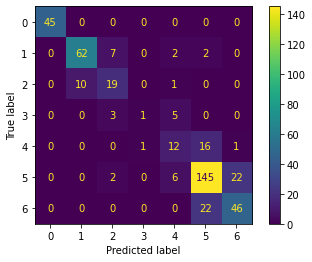

In [36]:
ConfusionMatrixDisplay(mat_2).plot()

In [43]:
mat_2.diagonal().sum()/mat_2.sum()

0.7674418604651163

In [44]:
(mat_2.diagonal().sum()+mat_2.diagonal(1).sum()+mat_2.diagonal(-1).sum())/mat_2.sum()

0.9813953488372092